# DATA SOURCE

1.privatepropertyindex

https://data.gov.sg/datasets?topics=housing&page=1&query=private+property+price+trend&resultId=d_97f8a2e995022d311c6c68cfda6d034c

2.hdb

https://data.gov.sg/datasets?topics=housing&page=1&query=price&resultId=d_14f63e595975691e7c24a27ae4c07c79

2.interestrates

https://eservices.mas.gov.sg/statistics/dir/DomesticInterestRates.aspx

3.gdp

https://tablebuilder.singstat.gov.sg/table/TS/M015651


In [30]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import pearsonr

# Filter for quarters between 2006 and 2024
# Becuase 3 months SORA was announed from 2005-3Q
df_private = pd.read_csv('privatepropertyindex.csv')
df_private = df_private[df_private['quarter'].str[:4].astype(int).between(2006,2024) ]
df_private['index'] = df_private['index'].astype(float)
df_private = df_private[df_private['property_type'] != 'All Residential']

df_hdb = pd.read_csv('HDBResaleIndex.csv')
df_hdb = df_hdb[df_hdb['quarter'].str[:4].astype(int).between(2006,2024)]
df_hdb['property_type'] = 'HDB'

df_merged = pd.merge(df_private, df_hdb, on=['quarter', 'property_type', 'index'], how='outer')

# Using 3 Months Compounded SORA for analysis
# because it is the benchmark rate for most variable-rate mortgages in Singapore.
df_interest = pd.read_csv('interestrates2.csv')
df_interest = df_interest.rename(columns={'SORA Publication Date':'Date', 'Compound SORA - 3 month':'rates'})

# Calculate the average interest rate per quarter
df_interest['Date'] = pd.to_datetime(df_interest['Date'], format='%d.%b.%y')
df_interest["quarter"] = df_interest["Date"].dt.to_period("Q")  # Convert to a quarterly basis

df_quarterly_interest = df_interest.groupby("quarter")["rates"].mean().reset_index()
df_quarterly_interest["quarter"] = df_quarterly_interest["quarter"].astype(str)
df_quarterly_interest["quarter"] = df_quarterly_interest["quarter"].str[:4] + "-" + df_quarterly_interest["quarter"].str[4:]
df_quarterly_interest = df_quarterly_interest[df_quarterly_interest['quarter'].str[:4].astype(int).between(2006,2024)]

df_merged = pd.merge(df_merged, df_quarterly_interest, on='quarter', how='inner')
df_merged.head()

,quarter,property_type,index,rates
0,2006-Q1,HDB,73.6,3.005674
1,2006-Q1,Landed,86.8,3.005674
2,2006-Q1,Non-Landed,85.7,3.005674
3,2006-Q2,HDB,74.3,3.133553
4,2006-Q2,Landed,88.2,3.133553


In [31]:
def describe_index(df):

  data = []
  for prop in df['property_type'].unique():
    describe_output = pd.DataFrame(df[df['property_type'] == prop]['index'].describe()).T
    data.append(describe_output)

  df_describe = pd.concat(data, ignore_index=True)
  df_describe.index = df['property_type'].unique()
  df_describe
  return df_describe

# Excute the function
describe_index(df_merged)


,count,mean,std,min,25%,50%,75%,max
HDB,76.0,132.596053,28.902228,73.6,123.625,134.60,145.950,197.9
Landed,76.0,162.427632,39.484618,86.8,149.475,165.85,177.275,243.8
Non-Landed,76.0,142.822368,26.272579,85.7,133.425,141.60,149.075,203.4


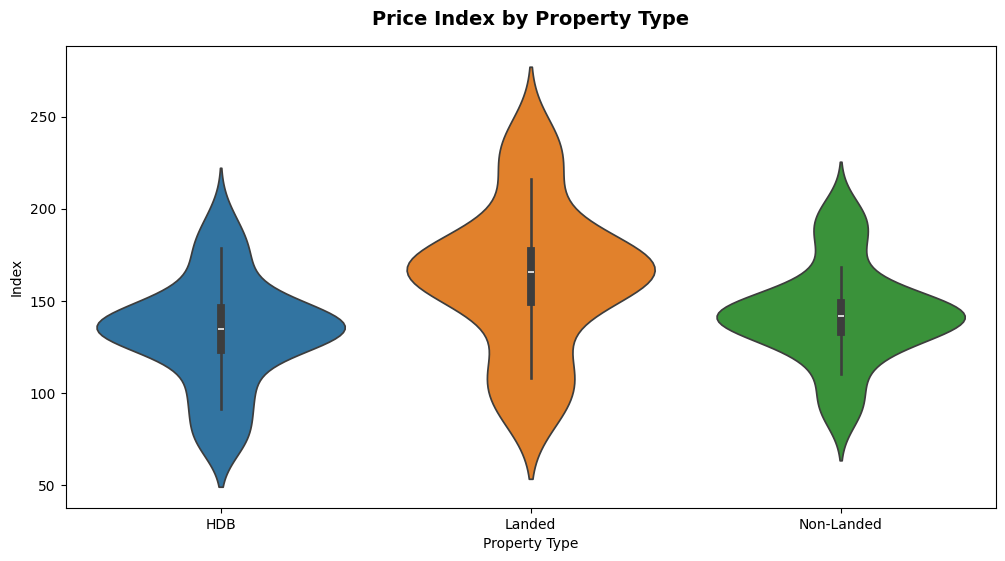

In [32]:
def return_violin(df_merged):
  """
  plot price index by property type as a violin plot
  """

  fig, ax = plt.subplots(figsize=(12,6))
  sns.violinplot(x='property_type', y='index', data=df_merged, ax=ax, hue ='property_type', legend=False )
  ax.set_xlabel('Property Type')
  ax.set_ylabel('Index')
  ax.set_title('Price Index by Property Type',fontsize=14, fontweight="bold", pad=15)
  plt.show()

# Excute the function
return_violin(df_merged)

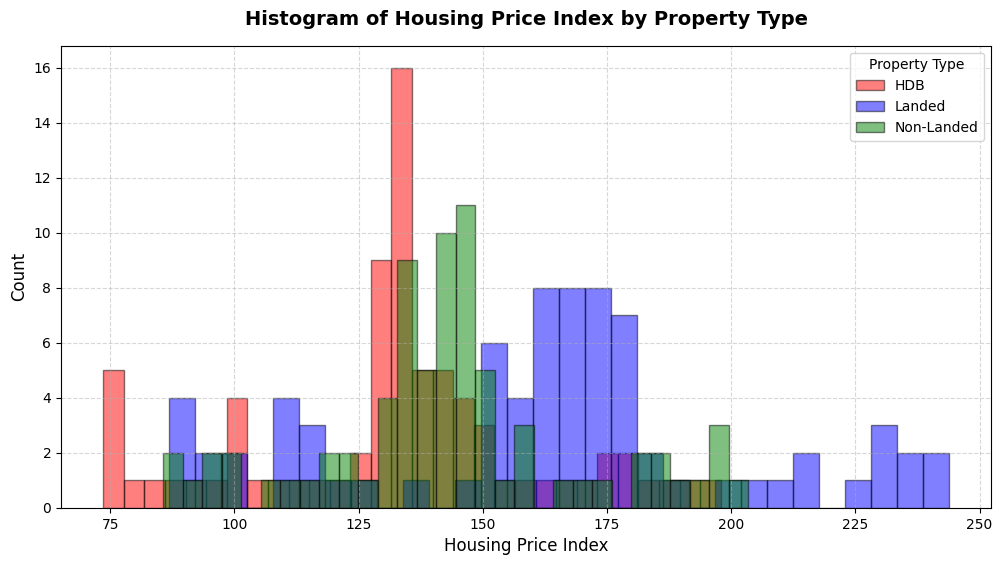

In [33]:
def plot_histogram_distributions(df):
    """
    Plots a histogram of the housing price index for each property type
    """

    plt.figure(figsize=(12,6))

    # Extract unique property types
    property_types = df['property_type'].unique()
    colors = ["red", "blue", "green"]  # Assign colors for each property type

    for prop, color in zip(property_types, colors):
        data = df[df['property_type'] == prop]['index']
        plt.hist(data, bins=30, alpha=0.5, color=color, label=prop, edgecolor="black")

    # Label and title settings
    plt.xlabel("Housing Price Index", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title("Histogram of Housing Price Index by Property Type", fontsize=14, fontweight="bold", pad=15)
    plt.legend(title="Property Type")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Execute function
plot_histogram_distributions(df_merged)

In [34]:
def print_stats(dist):
  """
  print moments of each property type
  """

  numeric_dist = df_merged.loc[df_merged['property_type'] == dist, 'index']
  print(f"Property Type: {dist}")
  print(f'mean : {np.mean(numeric_dist):.2f} +/- {ss.bootstrap((numeric_dist,), np.mean, confidence_level=0.682).standard_error:.2f}')
  print(f'std : {np.std(numeric_dist):.2f} +/- {ss.bootstrap((numeric_dist,), np.std, confidence_level=0.682).standard_error:.2f}')
  print(f'skew : {ss.skew(numeric_dist):.2f} +/- {ss.bootstrap((numeric_dist,), ss.skew, confidence_level=0.682).standard_error:.2f}')
  print(f'kurtosis : {ss.kurtosis(numeric_dist):.2f} +/- {ss.bootstrap((numeric_dist,), ss.kurtosis, confidence_level=0.682).standard_error:.2f}')
  return

for dist in df_merged['property_type'].unique():
  print_stats(dist)
  print()

Property Type: HDB
mean : 132.60 +/- 3.30
std : 28.71 +/- 2.33
skew : -0.16 +/- 0.18
kurtosis : 0.01 +/- 0.42

Property Type: Landed
mean : 162.43 +/- 4.48
std : 39.22 +/- 2.90
skew : -0.03 +/- 0.14
kurtosis : -0.32 +/- 0.35

Property Type: Non-Landed
mean : 142.82 +/- 3.00
std : 26.10 +/- 2.25
skew : 0.18 +/- 0.19
kurtosis : 0.27 +/- 0.48



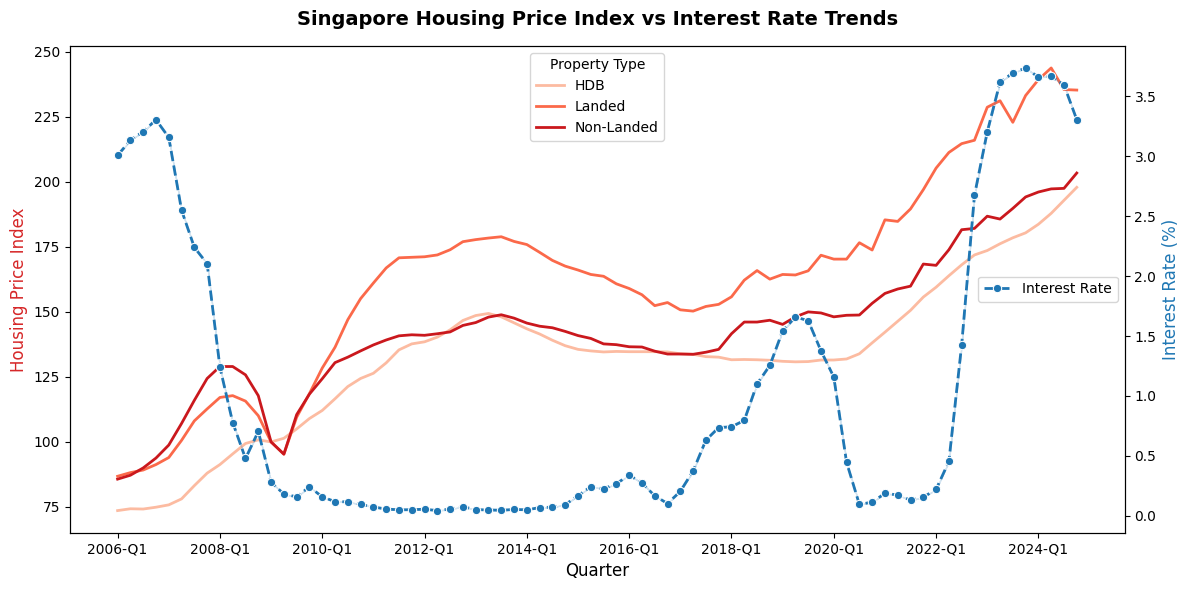

In [35]:
def plot_price_vs_interest(df_merged):
    """
    Plots the housing price index and interest rate trends on a dual-axis line chart.

    - The primary Y-axis represents the Housing Price Index.
    - The secondary Y-axis represents Interest Rates.
    """

    fig, ax1 = plt.subplots(figsize=(12,6))

    # First Y-axis: Housing Price Index
    ax1.set_xlabel("Quarter", fontsize=12)
    ax1.set_ylabel("Housing Price Index", color="tab:red", fontsize=12)
    sns.lineplot(x='quarter', y='index', hue='property_type', data=df_merged, ax=ax1, palette="Reds", linewidth=2)
    ax1.legend(title="Property Type", loc="upper center", fontsize=10)

    # Second Y-axis: Interest Rate
    ax2 = ax1.twinx()
    ax2.set_ylabel("Interest Rate (%)", color="tab:blue", fontsize=12)
    sns.lineplot(x="quarter", y="rates", data=df_merged, ax=ax2, color="tab:blue", linestyle="dashed", marker="o", label="Interest Rate", linewidth=2)
    ax2.legend(["Interest Rate"], loc="right", fontsize=10)

    # Adjust x-axis labels (spacing for better readability)
    unique_quarters = df_merged['quarter'].unique()
    plt.xticks(unique_quarters[::8], rotation=45)  # Show every 8th quarter label

    plt.title("Singapore Housing Price Index vs Interest Rate Trends", fontsize=14, fontweight="bold", pad=15)
    plt.tight_layout()
    plt.show()

# Excute the function
plot_price_vs_interest(df_merged)


In [36]:
def calculate_correlation(df):
    """
    calculate the Pearson correlation coefficient and p-value
    between interest rates and housing price index for each property type.
    """
    correlation_results = []

    for prop in df['property_type'].unique():
        subset = df[df['property_type'] == prop]

        # Compute Pearson correlation coefficient and p-value
        r_value, p_value = pearsonr(subset['rates'], subset['index'])
        correlation_results.append([prop, r_value, p_value])

    correlation_df = pd.DataFrame(correlation_results, columns=["Property Type", "Correlation", "P-Value"])

    return correlation_df

# Execute the function
correlation_df = calculate_correlation(df_merged)
correlation_df

,Property Type,Correlation,P-Value
0,HDB,0.085488,0.462790
1,Landed,0.156998,0.175605
2,Non-Landed,0.233377,0.042466
